In [ ]:
import os
import zipfile

import random
from time import time
from tqdm import tqdm
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset

from collections import defaultdict
from contextlib import contextmanager

import time

from PIL import Image
import csv

from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support

from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Load

In [ ]:
# transform the image: resize, toTensor, normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def custom_dataloader(data_dir, transform, batch_size=64, num_workers=1):

  '''
  input:
    data_dir: file path of the input data. e.g. /content/extracted_data/wikiART224
    transform: data transform
    batch_size
    num_workers
  output:
    train_loader, val_loader, test_loader
  -----
  data is transformed by transform. train:val:test = 0.8:0.1:0.1 with each classes equally splitted
    '''

  raw_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
  print(raw_dataset)
  num_classes = len(raw_dataset.classes)
  print("Number of classes:", num_classes)
  np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
  indices = np.arange(len(raw_dataset))
  np.random.shuffle(indices)
  train_split = int(len(indices) * 0.8)
  testval_split = train_split + int(len(indices) * (1 - 0.8)/2)
  # split into training and validation indices
  relevant_train_indices, relevant_val_indices,test_indices = indices[:train_split], indices[train_split:testval_split] ,indices[testval_split:]
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=train_sampler)
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                            num_workers=num_workers, sampler=val_sampler)
  test_sampler = SubsetRandomSampler(test_indices)
  test_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=test_sampler)
  print(f'data loading completed')
  return train_loader, val_loader, test_loader

In [ ]:
### MODIFY ###
'''
rawdata_dir: file path of the extracted data. e.g. /content/extracted_data/wikiART224
save_dir: file path for the saved data. e.g. /content/drive/MyDrive/UofT/MIE1517/project/subset fine tune/
'''
rawdata_dir = '/content/extracted_data_subset13'
save_dir = '/content/drive/MyDrive/UofT/MIE1517/project/subset fine tune/'

In [ ]:
train_loader, val_loader, test_loader = custom_dataloader(rawdata_dir, transform)

Dataset ImageFolder
    Number of datapoints: 69125
    Root location: /content/extracted_data_subset13/wikiART224
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Number of classes: 13
data loading completed


In [ ]:
used_class = ['Abstract_Expressionism',
              'Art_Nouveau_Modern',
              'Baroque',
              'Cubism',
              'Expressionism',
              'Impressionism',
              'Naive_Art_Primitivism',
              'Northern_Renaissance',
              'Post_Impressionism',
              'Realism',
              'Rococo',
              'Romanticism',
              'Symbolism']

# Define model

In [ ]:
class StyleResNet50_5(nn.Module):
  def __init__(self, hidden_dim1=1024, hidden_dim2=256):
    super(StyleResNet50_5, self).__init__()

    resnet = models.resnet50(pretrained=True)
    self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])

    self.fc1 = nn.Linear(2048, hidden_dim1)
    self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
    self.fc3 = nn.Linear(hidden_dim2, 13)
    self.dropout = nn.Dropout(p=0.5)
    self.flatten = nn.Flatten()
    self.leaky_relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)


  def forward(self, x):
    x = self.resnet_features(x)
    x = self.flatten(x)
    x = self.dropout(x)
    x = self.leaky_relu(self.fc1(x))
    x = self.dropout(x)
    x = self.leaky_relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)

    return x

# Training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [ ]:
def plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, elapsed_time):
    print(f'elapsed time: {elapsed_time}')
    iterations = range(1, len(train_losses) + 1)
    # Plot Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, train_losses, label='Train Loss', color='blue')
    plt.plot(iterations, valid_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    epochs = range(1, len(train_accuracies) + 1)
    # Plot Accuracy Curve
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, labels in data_loader:
          data, labels = data.to(device), labels.to(device)
          output = model(data)
          loss = criterion(output, labels)
          total_loss += loss.item() * data.size(0)
          pred = output.max(1, keepdim=True)[1]
          total_correct += pred.eq(labels.view_as(pred)).sum().item()
          total_samples += data.size(0)

    accuracy = total_correct / total_samples
    average_loss = total_loss / total_samples

    return average_loss, accuracy

In [ ]:
def train_model(model, model_name, train_loader, valid_loader, device, save_dir, num_epochs=4, lr=0.0001, wd=0, clip_gradient=None):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    for epoch in range(num_epochs):

        running_loss = 0.0
        running_pred = 0.0
        running_total = 0.0
        tqdm_bar = tqdm(train_loader)

        for batch_idx, (inputs, labels) in enumerate(tqdm_bar):
            with torch.set_grad_enabled(True):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                loss.backward()
                if clip_gradient is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                pred = outputs.max(1, keepdim=True)[1]
                running_pred += pred.eq(labels.view_as(pred)).sum().item()
                running_total += pred.shape[0]


        train_acc = running_pred / running_total
        train_loss = running_loss / running_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        running_loss = 0.0
        running_pred = 0.0
        running_total = 0.0
        valid_loss, valid_acc = evaluate_model(model, valid_loader, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, '
              f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}')
        model.train()

        joblib.dump(model, f'{save_dir}{model_name}_epoch{epoch+1}.joblib')

        results = pd.DataFrame({'train loss': train_losses, 'valid loss': valid_losses, 'train accuracy': train_accuracies, 'valid accuracy': valid_accuracies})
        results.to_csv(f'{save_dir}{model_name}_results.csv')
    end_time = time.time()
    elapsed_time = end_time - start_time
    plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, elapsed_time)


    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

##TRAIN WIkiART224

100%|██████████| 865/865 [09:17<00:00,  1.55it/s]


Epoch [1/5], Step [865/865], Training Loss: 1.6846, Training Accuracy: 0.4228, Validation Loss: 1.3637, Validation Accuracy: 0.5307


100%|██████████| 865/865 [09:15<00:00,  1.56it/s]


Epoch [2/5], Step [865/865], Training Loss: 1.2385, Training Accuracy: 0.5780, Validation Loss: 1.2263, Validation Accuracy: 0.5731


100%|██████████| 865/865 [09:14<00:00,  1.56it/s]


Epoch [3/5], Step [865/865], Training Loss: 0.9498, Training Accuracy: 0.6796, Validation Loss: 1.2707, Validation Accuracy: 0.5836


100%|██████████| 865/865 [09:14<00:00,  1.56it/s]


Epoch [4/5], Step [865/865], Training Loss: 0.6866, Training Accuracy: 0.7702, Validation Loss: 1.3270, Validation Accuracy: 0.5689


100%|██████████| 865/865 [09:15<00:00,  1.56it/s]


Epoch [5/5], Step [865/865], Training Loss: 0.4974, Training Accuracy: 0.8379, Validation Loss: 1.5834, Validation Accuracy: 0.5551
elapsed time: 2894.4849429130554


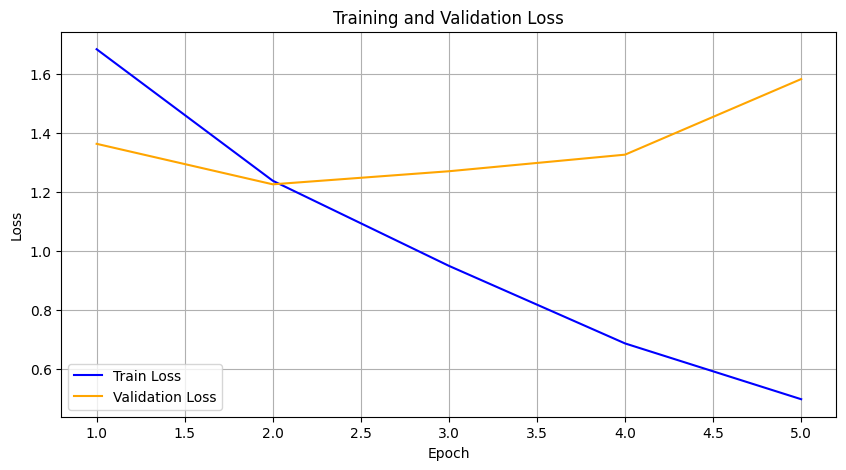

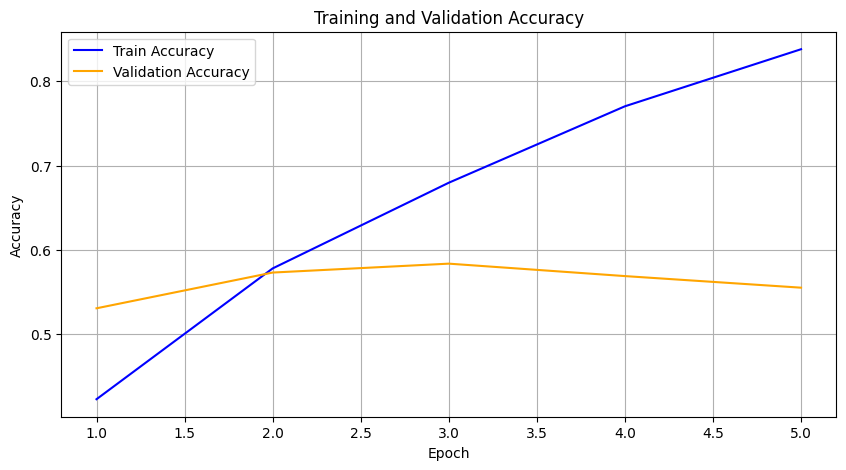

In [ ]:
model = StyleResNet50_5()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'model_50_5', train_loader, val_loader, device,num_epochs = 5, clip_gradient=1.0)

# Evaluate Function

In [ ]:
def precision_at_k(y_true, y_pred, k=3):
    top_k_indices = np.argsort(y_pred, axis=1)[:, -k:]  # Get indices of top k predictions for each example
    num_examples = len(y_true)
    correct_predictions = 0
    for i in range(num_examples):
        if y_true[i] in top_k_indices[i]:
            correct_predictions += 1
    precision = correct_predictions
    return precision

In [ ]:
def evaluate_result(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_precision = 0
    total_correct = 0
    total_samples = 0
    y_hat_epoch = []
    y_true_epoch = []

    i = 0

    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():

        for data, labels in data_loader:
          data, labels = data.to(device), labels.to(device)
          output = model(data)
          loss = criterion(output, labels)
          total_loss += loss.item() * data.size(0)

          prob = nn.Softmax(dim=1)(output)
          pred = prob.max(1, keepdim=True)[1]
          total_correct += pred.eq(labels.view_as(pred)).sum().item()

          precision = precision_at_k(labels.cpu().numpy(), output.cpu().numpy(), k=3)
          total_precision += precision

          total_samples += data.size(0)
          y_hat_epoch.append(pred.cpu().numpy())
          y_true_epoch.append(labels.cpu().numpy())

    y_hat_epoch = np.concatenate(y_hat_epoch, axis=None)
    y_true_epoch = np.concatenate(y_true_epoch, axis=None)

    precision_k = total_precision / total_samples
    average_loss = total_loss / total_samples
    accuracies = total_correct / total_samples
    scores = precision_recall_fscore_support(np.array(y_true_epoch), np.array(y_hat_epoch))
    results = pd.DataFrame({'loss': average_loss, 'accuracy': accuracies, 'topk': precision_k,
                            'precision': scores[0], 'recall': scores[1], 'f1': scores[2]})

    return average_loss, accuracies, precision_k, scores, y_true_epoch, y_hat_epoch,

# Evaluate

### metrics

In [ ]:
best_model = joblib.load(f'{save_dir}model_50_5_epoch3.joblib')
train_average_loss, train_accuracies, train_precision_k, train_scores, y_ture_train, y_hat_train = evaluate_result(best_model, train_loader, device)
val_average_loss, val_accuracies, val_precision_k, val_scores, y_true_val, y_hat_val = evaluate_result(best_model, val_loader, device)
test_average_loss, test_accuracies, test_precision_k, test_scores, y_true_test, y_hat_test = evaluate_result(best_model, test_loader, device)

In [ ]:
losses = pd.DataFrame({'losses': [train_average_loss, val_average_loss, test_average_loss],
                       'accuracy': [train_accuracies, val_accuracies, test_accuracies],
                       'k accuracy': [train_precision_k, val_precision_k, test_precision_k]})
losses.index = ['train', 'val', 'test']

losses.to_csv(f'{save_dir}metrics/losses.csv')

In [ ]:
losses

,losses,accuracy,k accuracy
train,0.588948,0.803671,0.962333
val,1.270694,0.583623,0.865307
test,1.270794,0.587444,0.862867


In [ ]:
precision_metrics = pd.DataFrame({'train precision': train_scores[0], 'val precision': val_scores[0], 'test precision': test_scores[0],
                                  'train recall':train_scores[1], 'val recall': val_scores[1], 'test recall': test_scores[1],
                                  'train f1': train_scores[2], 'val f1': val_scores[2], 'test f1': test_scores[2]})
precision_metrics.index =  used_class
precision_metrics.to_csv(f'{save_dir}metrics/precision metrics.csv')

In [ ]:
precision_metrics

,train precision,val precision,test precision,train recall,val recall,test recall,train f1,val f1,test f1
Abstract_Expressionism,0.828008,0.609195,0.662069,0.942947,0.770909,0.683274,0.881748,0.680578,0.672504
Art_Nouveau_Modern,0.826470,0.630178,0.625668,0.758074,0.514493,0.528217,0.790796,0.566489,0.572827
Baroque,0.865530,0.645161,0.643172,0.909251,0.668258,0.703614,0.886852,0.656506,0.672037
Cubism,0.877181,0.712418,0.750000,0.742614,0.473913,0.502041,0.804308,0.569191,0.601467
Expressionism,0.780848,0.501859,0.478689,0.695853,0.397644,0.445802,0.735904,0.443714,0.461660
Impressionism,0.845899,0.680534,0.694570,0.832359,0.676287,0.685778,0.839074,0.678404,0.690146
Naive_Art_Primitivism,0.843149,0.626667,0.662252,0.696721,0.417778,0.452489,0.762973,0.501333,0.537634
Northern_Renaissance,0.932958,0.802326,0.795122,0.908774,0.736655,0.654618,0.920707,0.768089,0.718062
Post_Impressionism,0.639342,0.434426,0.398524,0.756606,0.566412,0.533773,0.693048,0.491716,0.456338
Realism,0.748386,0.514844,0.523988,0.864515,0.660781,0.651445,0.802270,0.578755,0.580806


### confusion matrix

In [ ]:
def plot_confusion(Y_hat, Y_test, classes, title):
  '''input: Y_hat, Y_test: list
            raw_datset: ImageFoldered data'''

  C = confusion_matrix(Y_test, Y_hat)

  C_df = pd.DataFrame(C,
                       index = classes,
                       columns = classes)

  plt.figure(figsize=(11,10), dpi=300)
  sns.heatmap(C_df, annot=True, fmt='d', cmap='Blues')
  plt.title(f'Confusion Matrix of {title}')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()
  return C

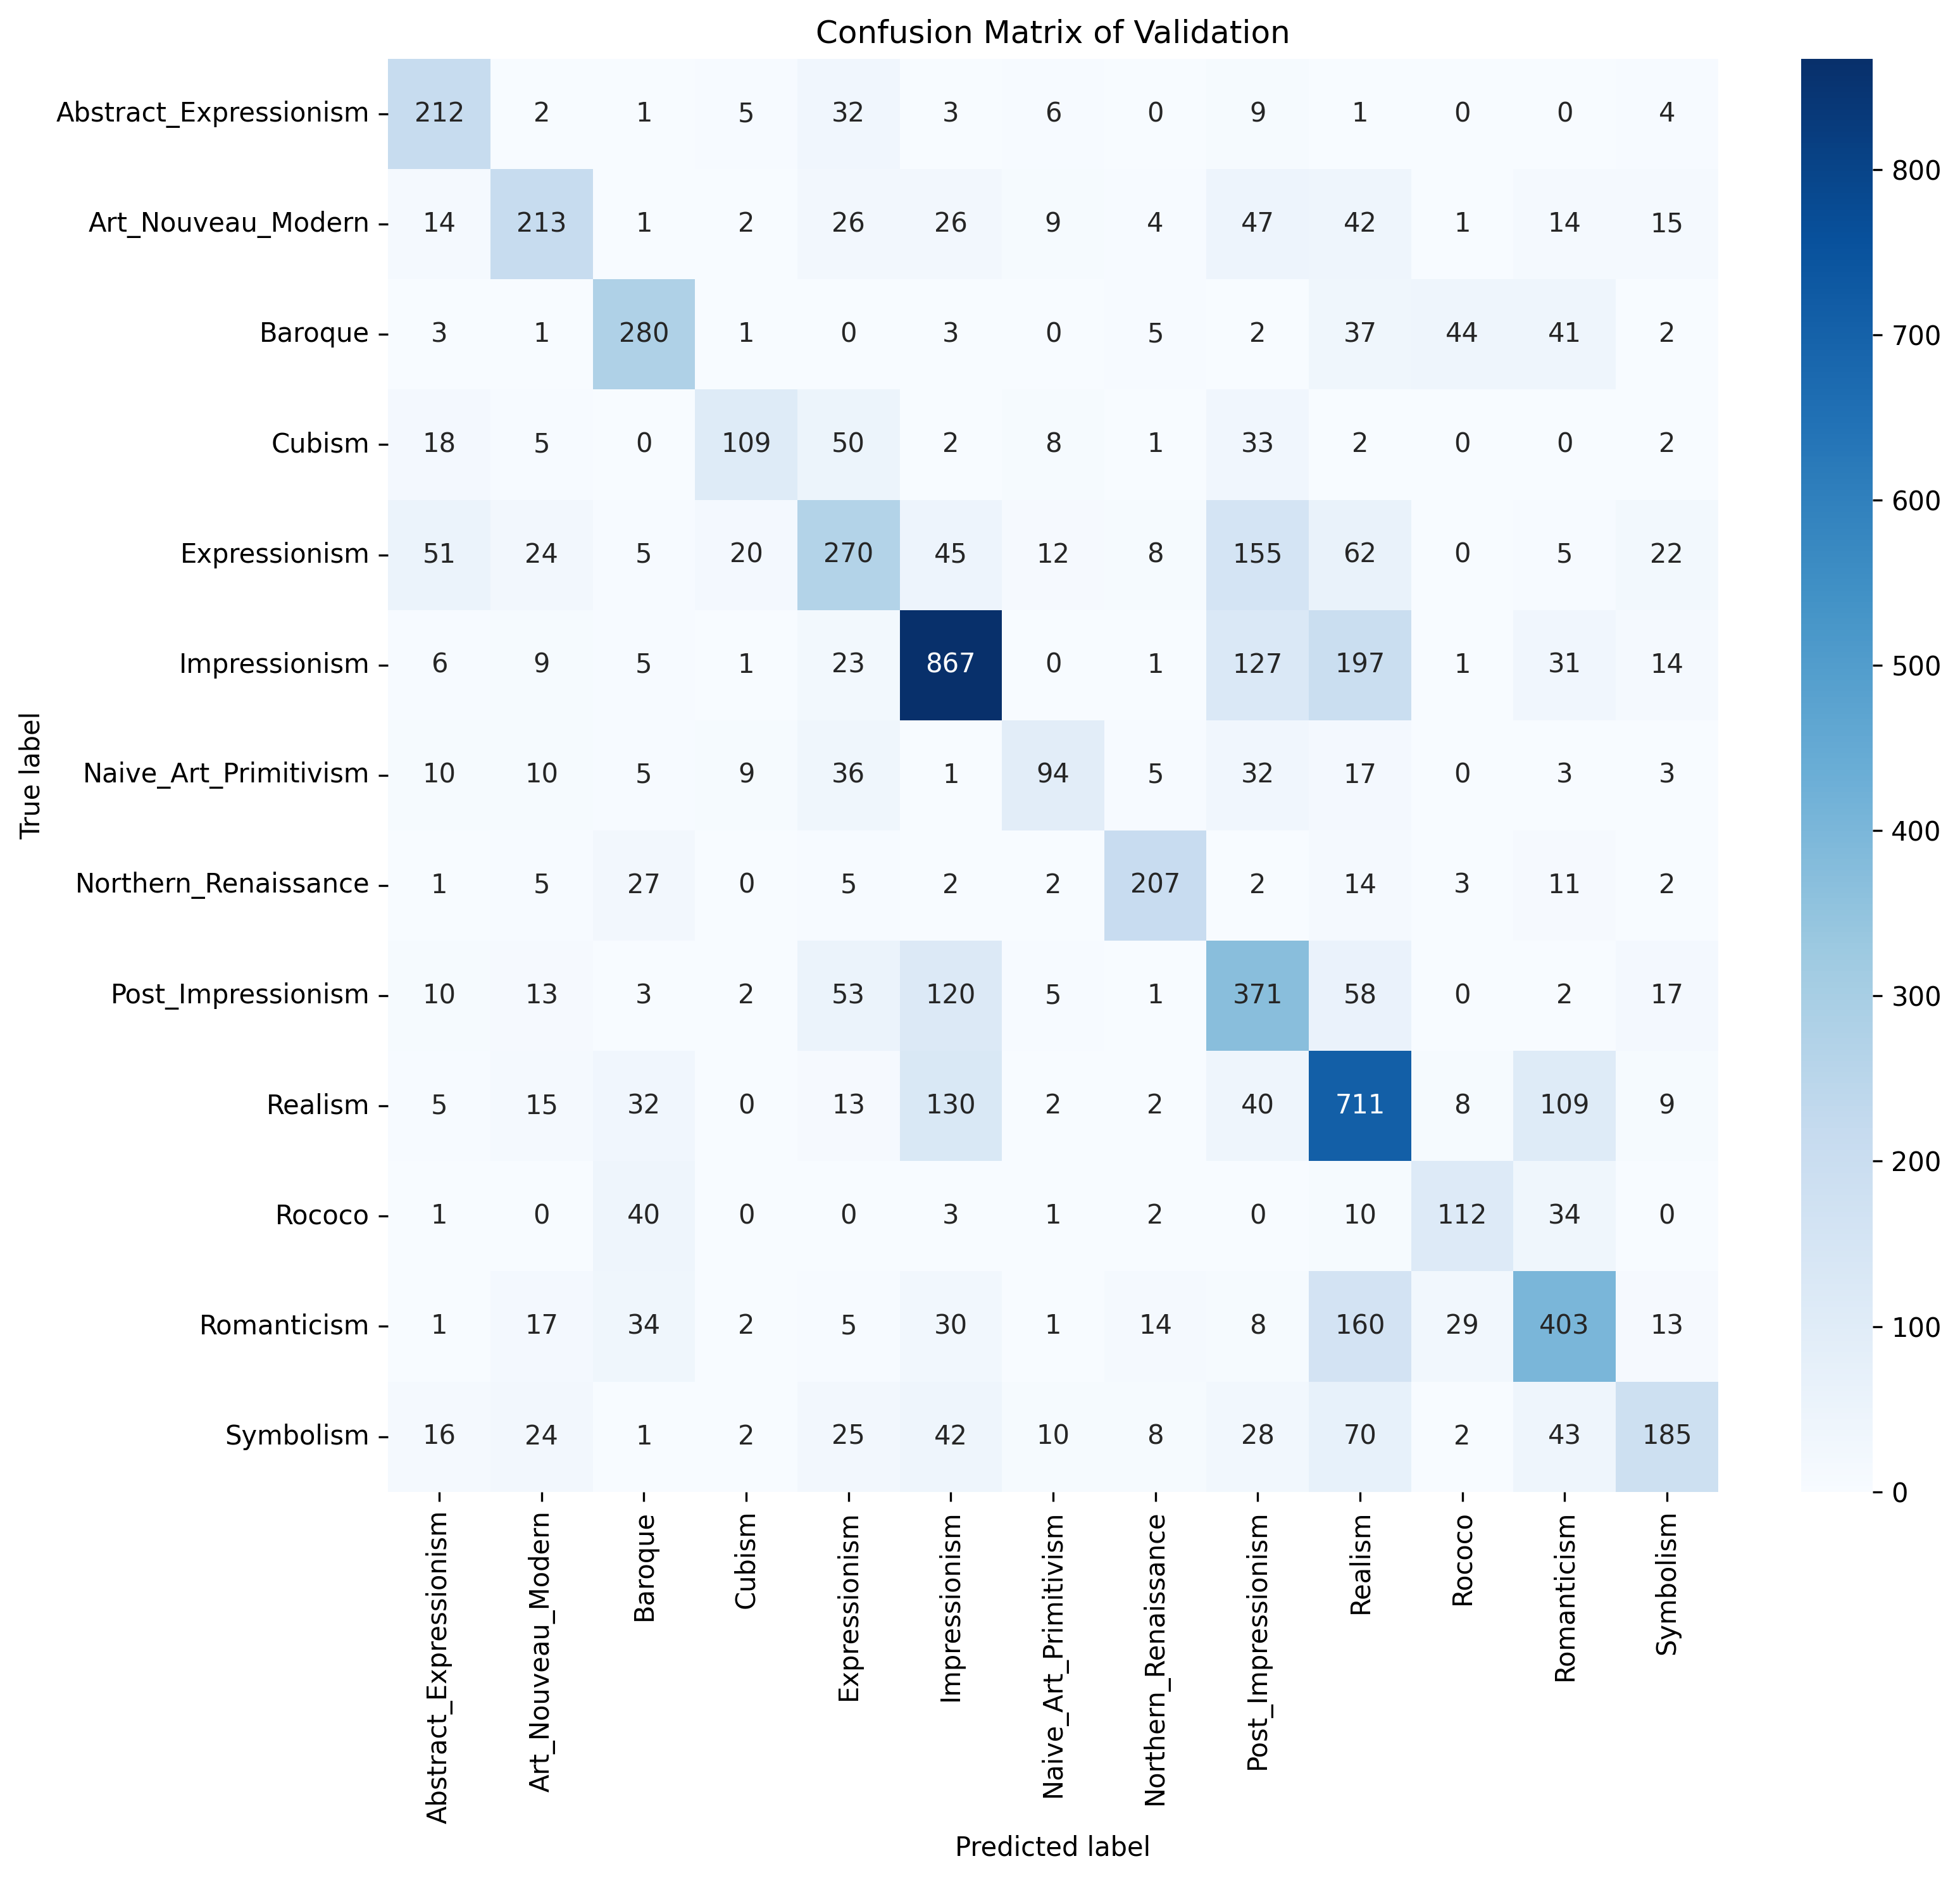

In [ ]:
C_val = plot_confusion(y_hat_val, y_true_val, used_class, 'Validation')

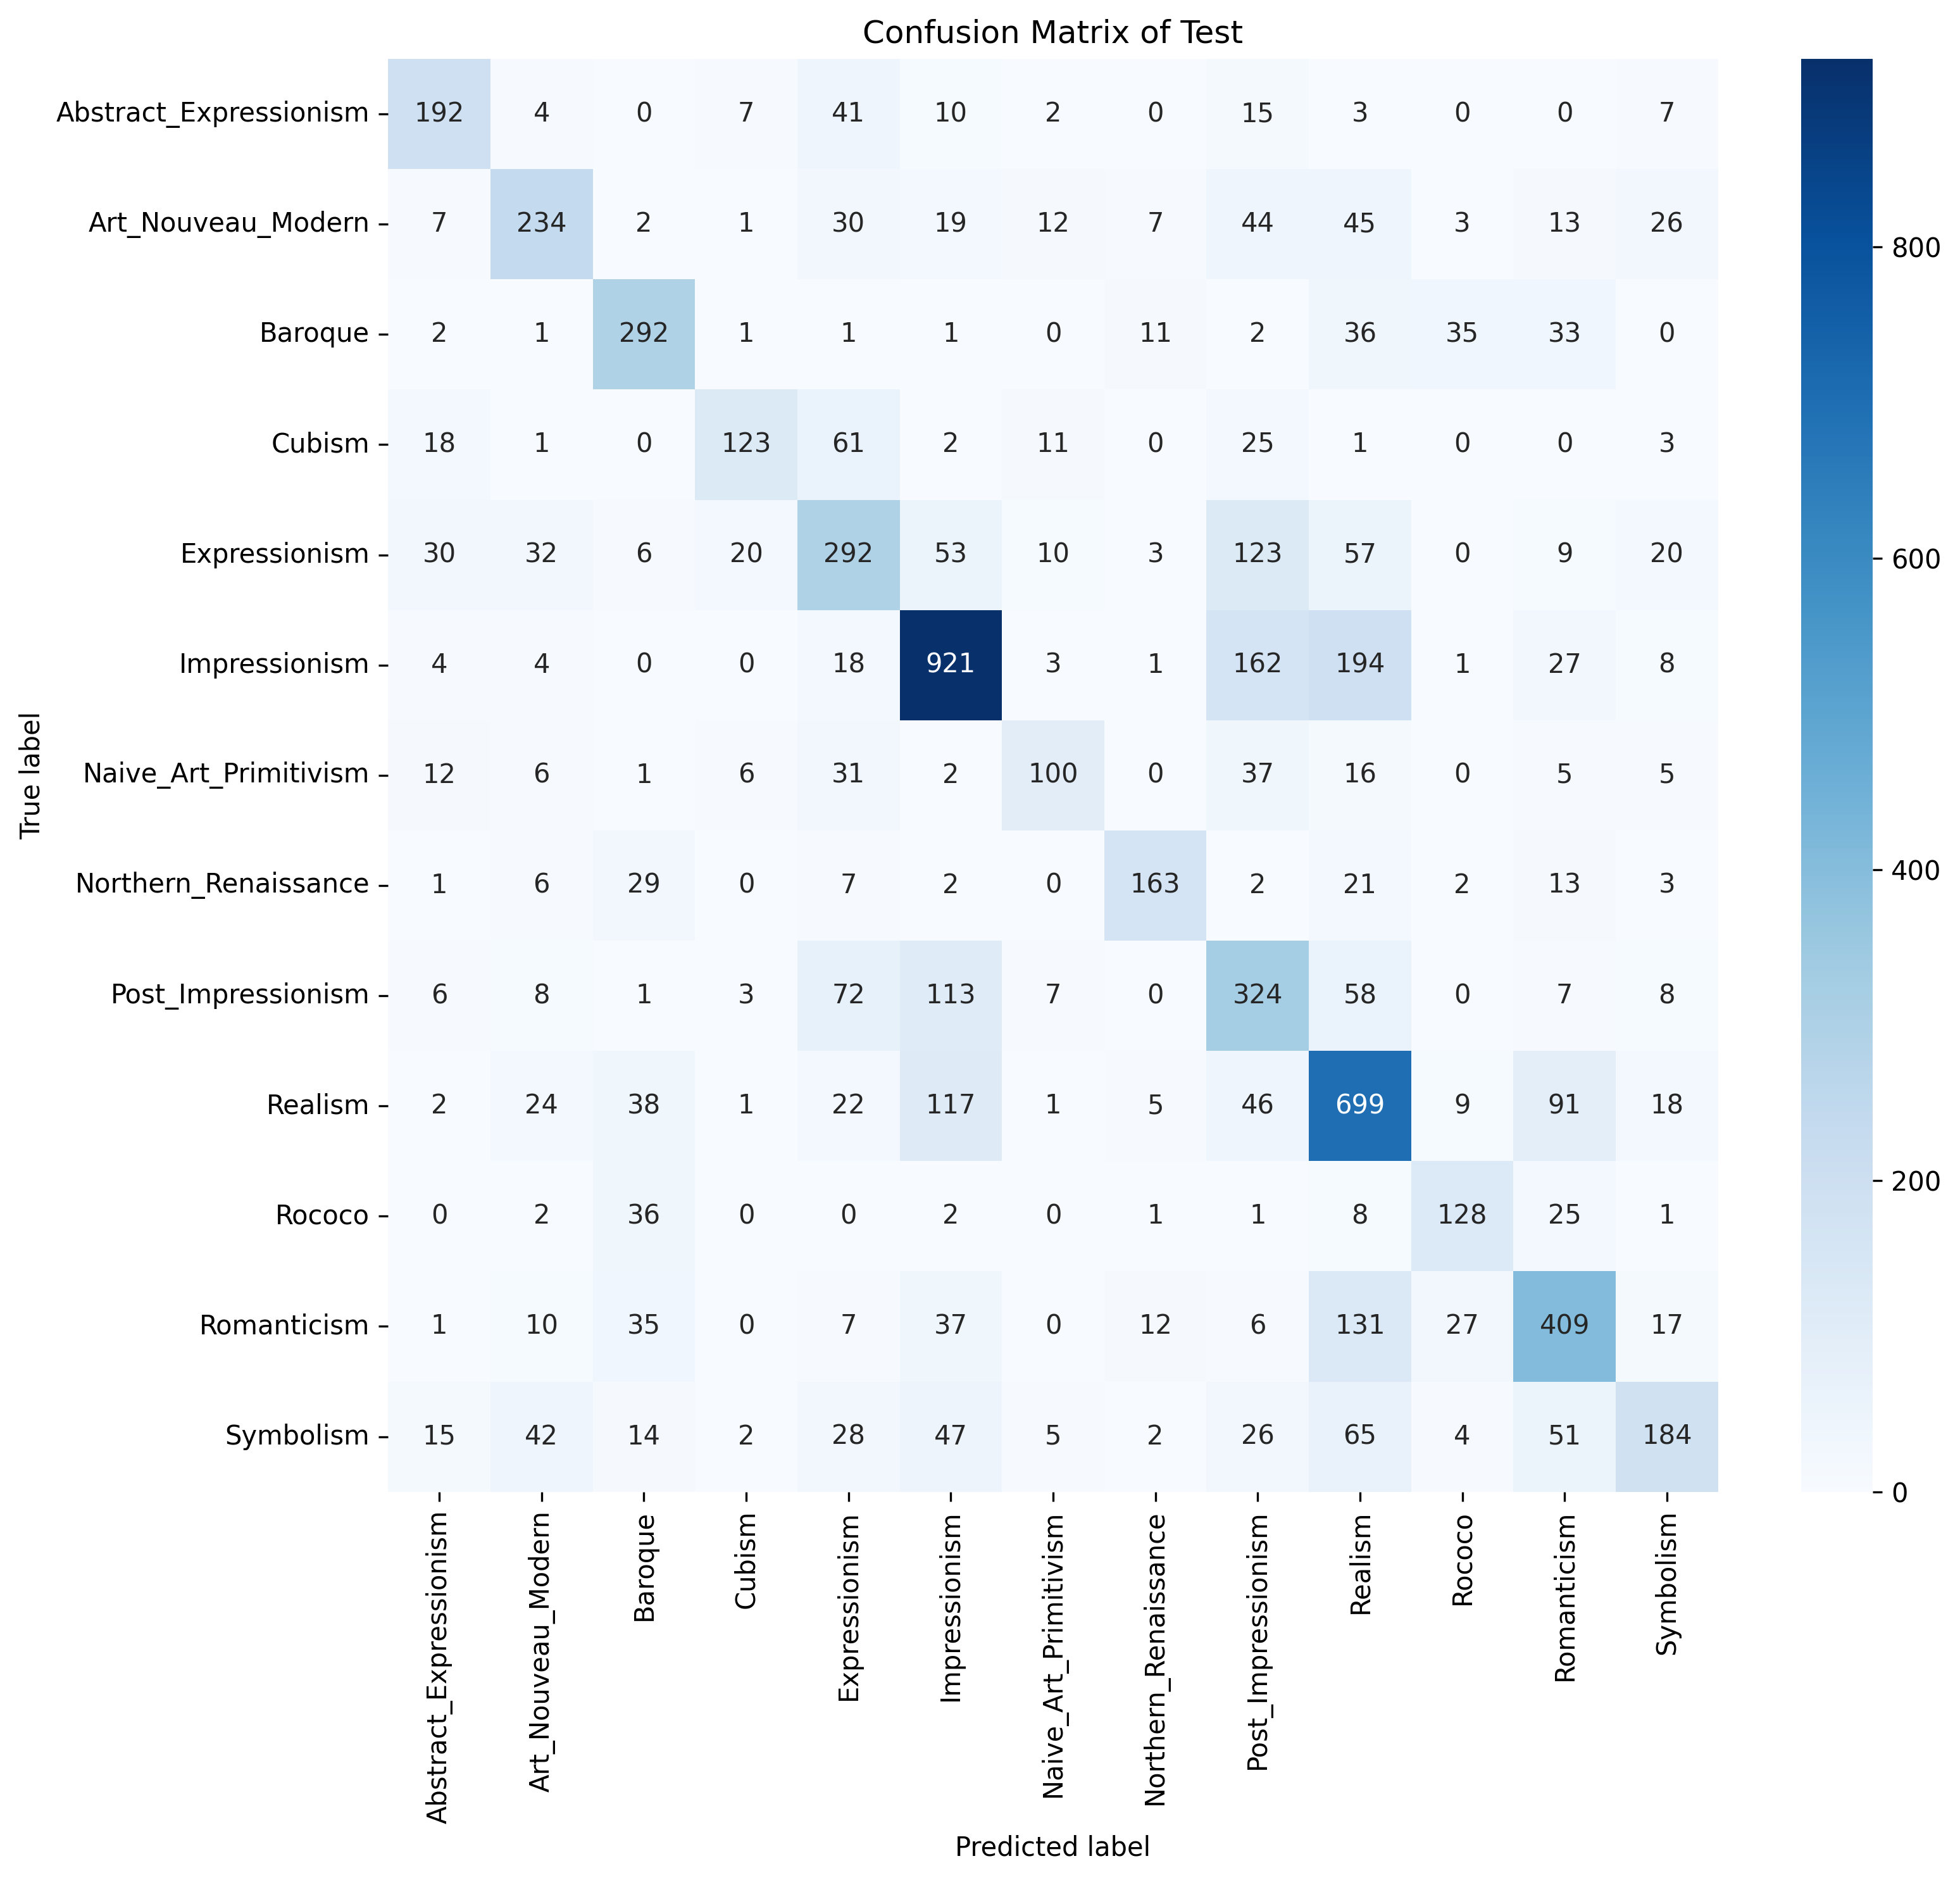

In [ ]:
C_test = plot_confusion(y_hat_test, y_true_test, used_class, 'Test')

### predicted labels

In [ ]:
predicted = pd.DataFrame()
for true_label in range(len(used_class)):
  indices = np.where(y_true_test == true_label)[0]

  elements = y_hat_test[indices]
  counter = Counter(elements)
  sorted_counter = sorted(counter.items(), key=lambda x: x[0])

  # rearange sorted_counter to have fixed length and fixed order
  for i in range(len(used_class)-1):
    if sorted_counter[i][0] != i:
      sorted_counter.append((i, 0))
      sorted_counter = sorted(sorted_counter, key=lambda x: x[0])
  if len(sorted_counter) < len(used_class):
    sorted_counter.append((len(used_class)-1, 0))

  counts = []
  for value, count in sorted_counter:
      counts.append(count)

  while len(counts) < 12:
        counts.append(np.nan)
  predicted[f'{used_class[true_label]}'] = counts

predicted.index = used_class
predicted.index.name = 'predicted class'

predicted.to_csv(f'{save_dir}metrics/predicted classes.csv')

In [ ]:
predicted

,Abstract_Expressionism,Art_Nouveau_Modern,Baroque,Cubism,Expressionism,Impressionism,Naive_Art_Primitivism,Northern_Renaissance,Post_Impressionism,Realism,Rococo,Romanticism,Symbolism
predicted class,,,,,,,,,,,,,
Abstract_Expressionism,192,7,2,18,30,4,12,1,6,2,0,1,15
Art_Nouveau_Modern,4,234,1,1,32,4,6,6,8,24,2,10,42
Baroque,0,2,292,0,6,0,1,29,1,38,36,35,14
Cubism,7,1,1,123,20,0,6,0,3,1,0,0,2
Expressionism,41,30,1,61,292,18,31,7,72,22,0,7,28
Impressionism,10,19,1,2,53,921,2,2,113,117,2,37,47
Naive_Art_Primitivism,2,12,0,11,10,3,100,0,7,1,0,0,5
Northern_Renaissance,0,7,11,0,3,1,0,163,0,5,1,12,2
Post_Impressionism,15,44,2,25,123,162,37,2,324,46,1,6,26


In [ ]:
curve = pd.read_csv(f'{save_dir}model_50_5_results.csv')
curve

,Unnamed: 0,train loss,valid loss,train accuracy,valid accuracy
0,0,1.684610,1.363718,0.422839,0.530671
1,1,1.238484,1.226329,0.577957,0.573061
2,2,0.949761,1.270694,0.679584,0.583623
3,3,0.686627,1.326951,0.770235,0.568866
4,4,0.497358,1.583367,0.837920,0.555122


In [ ]:
def plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)
    # Plot Loss Curve
    plt.figure(figsize=(10, 5), dpi=300)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, valid_losses, label='Validation Loss', color='orange')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Accuracy Curve
    plt.figure(figsize=(10, 5), dpi=300)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

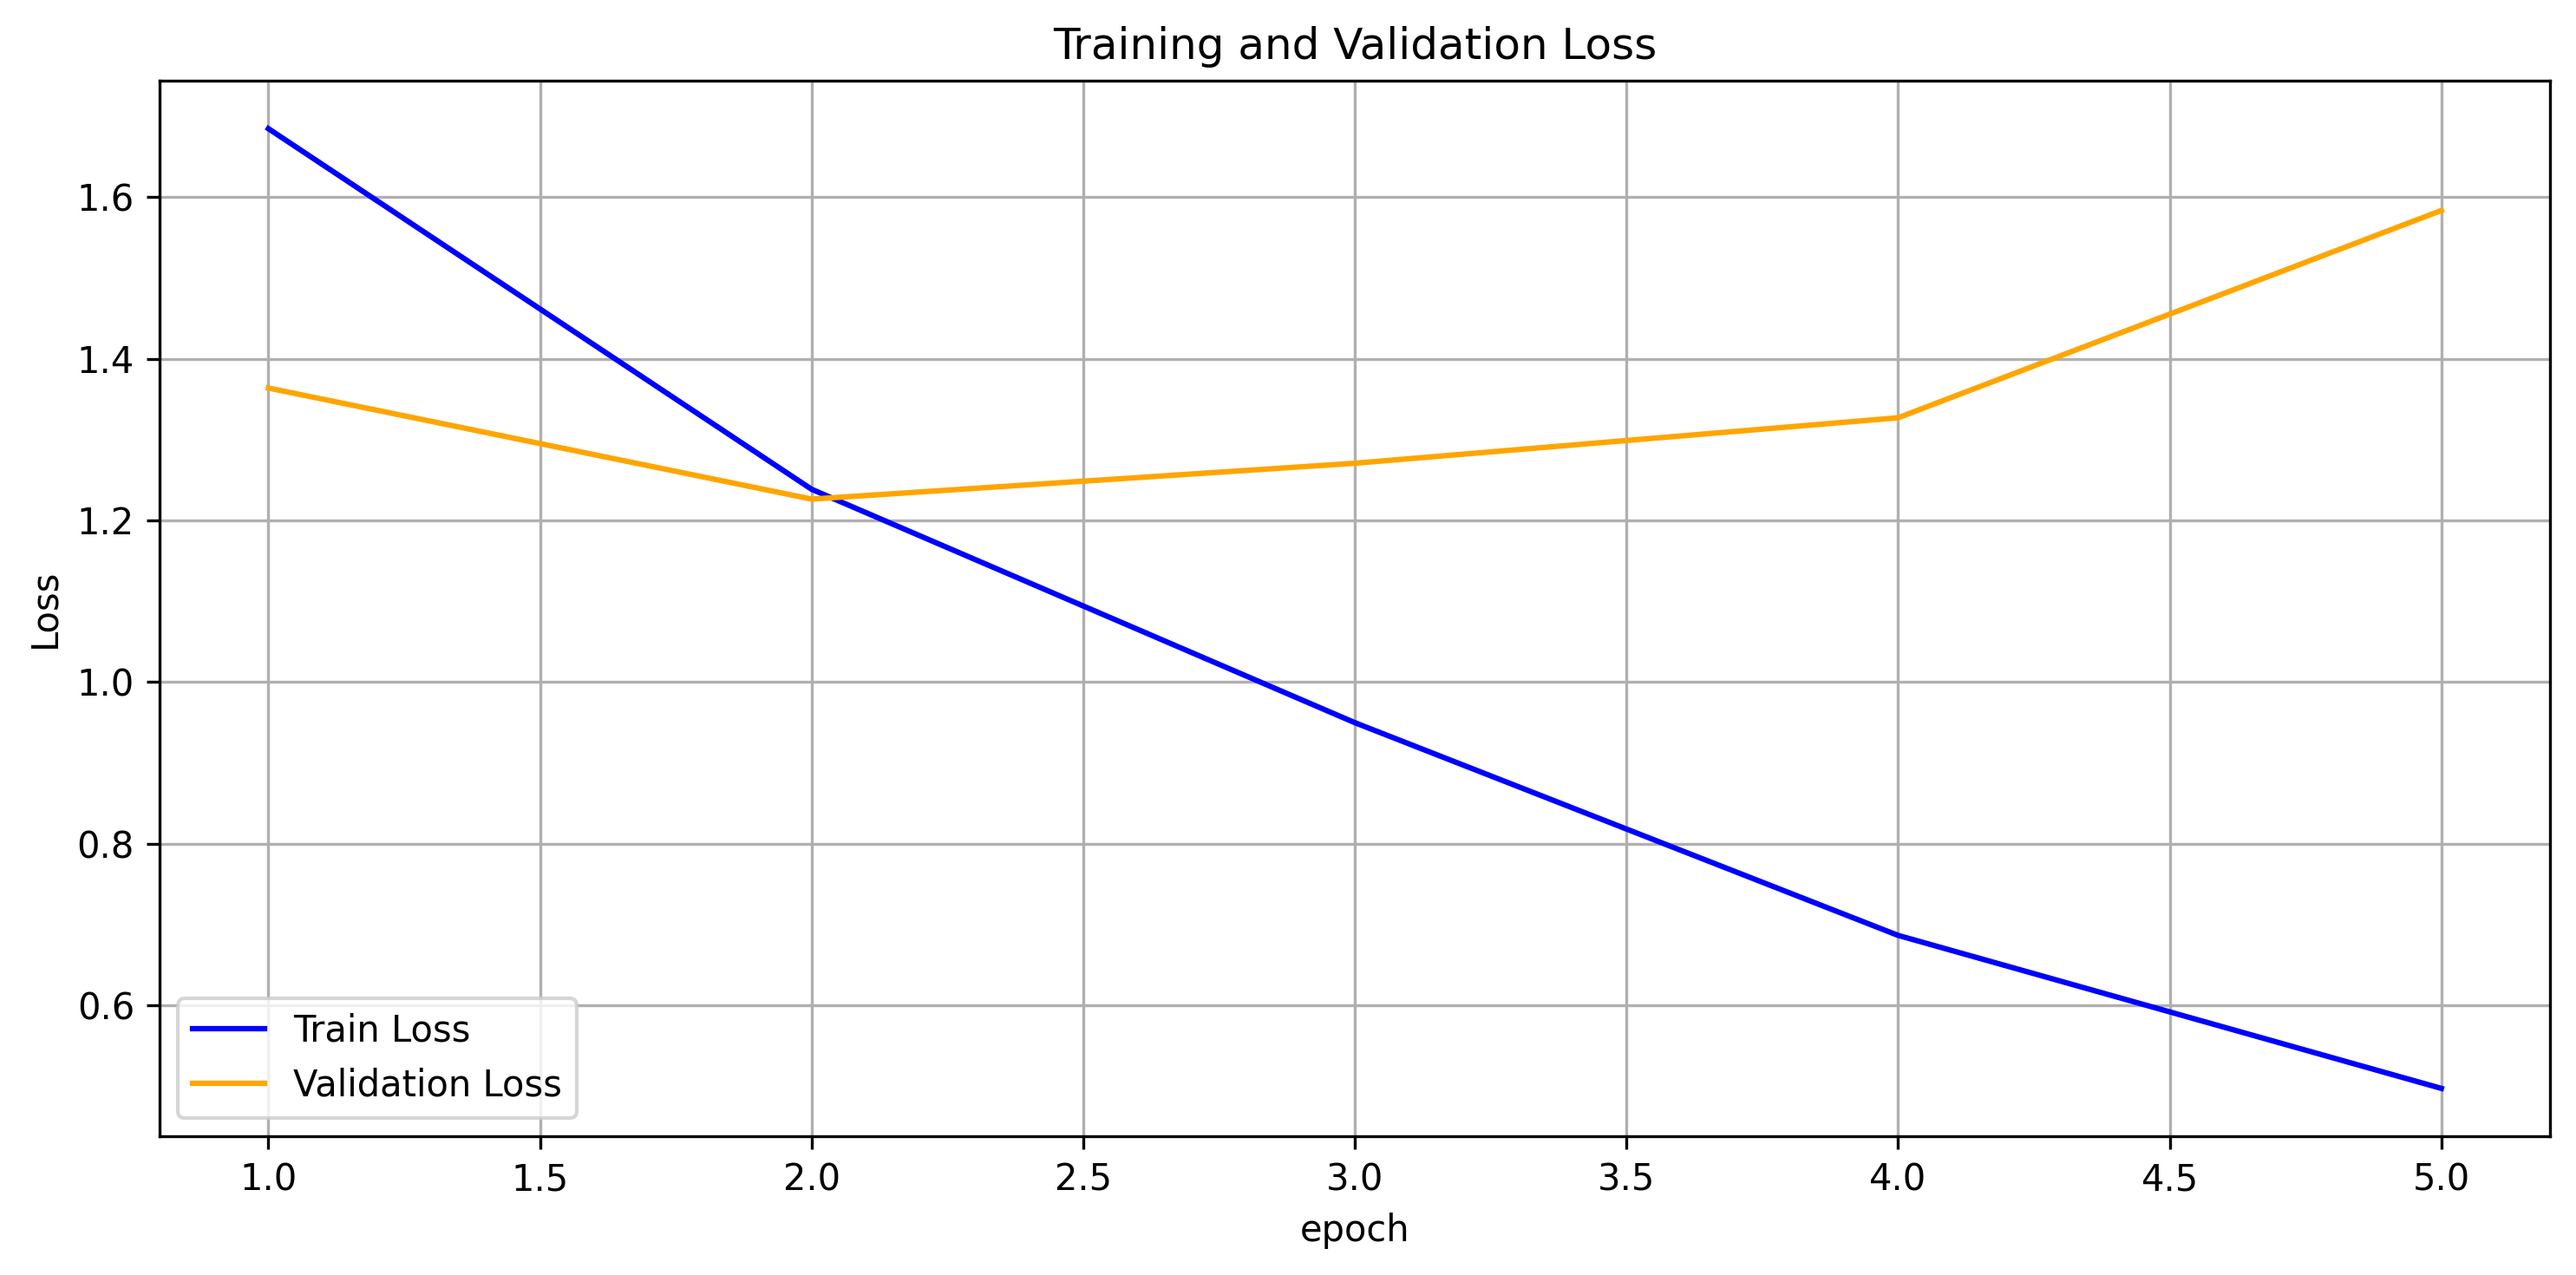

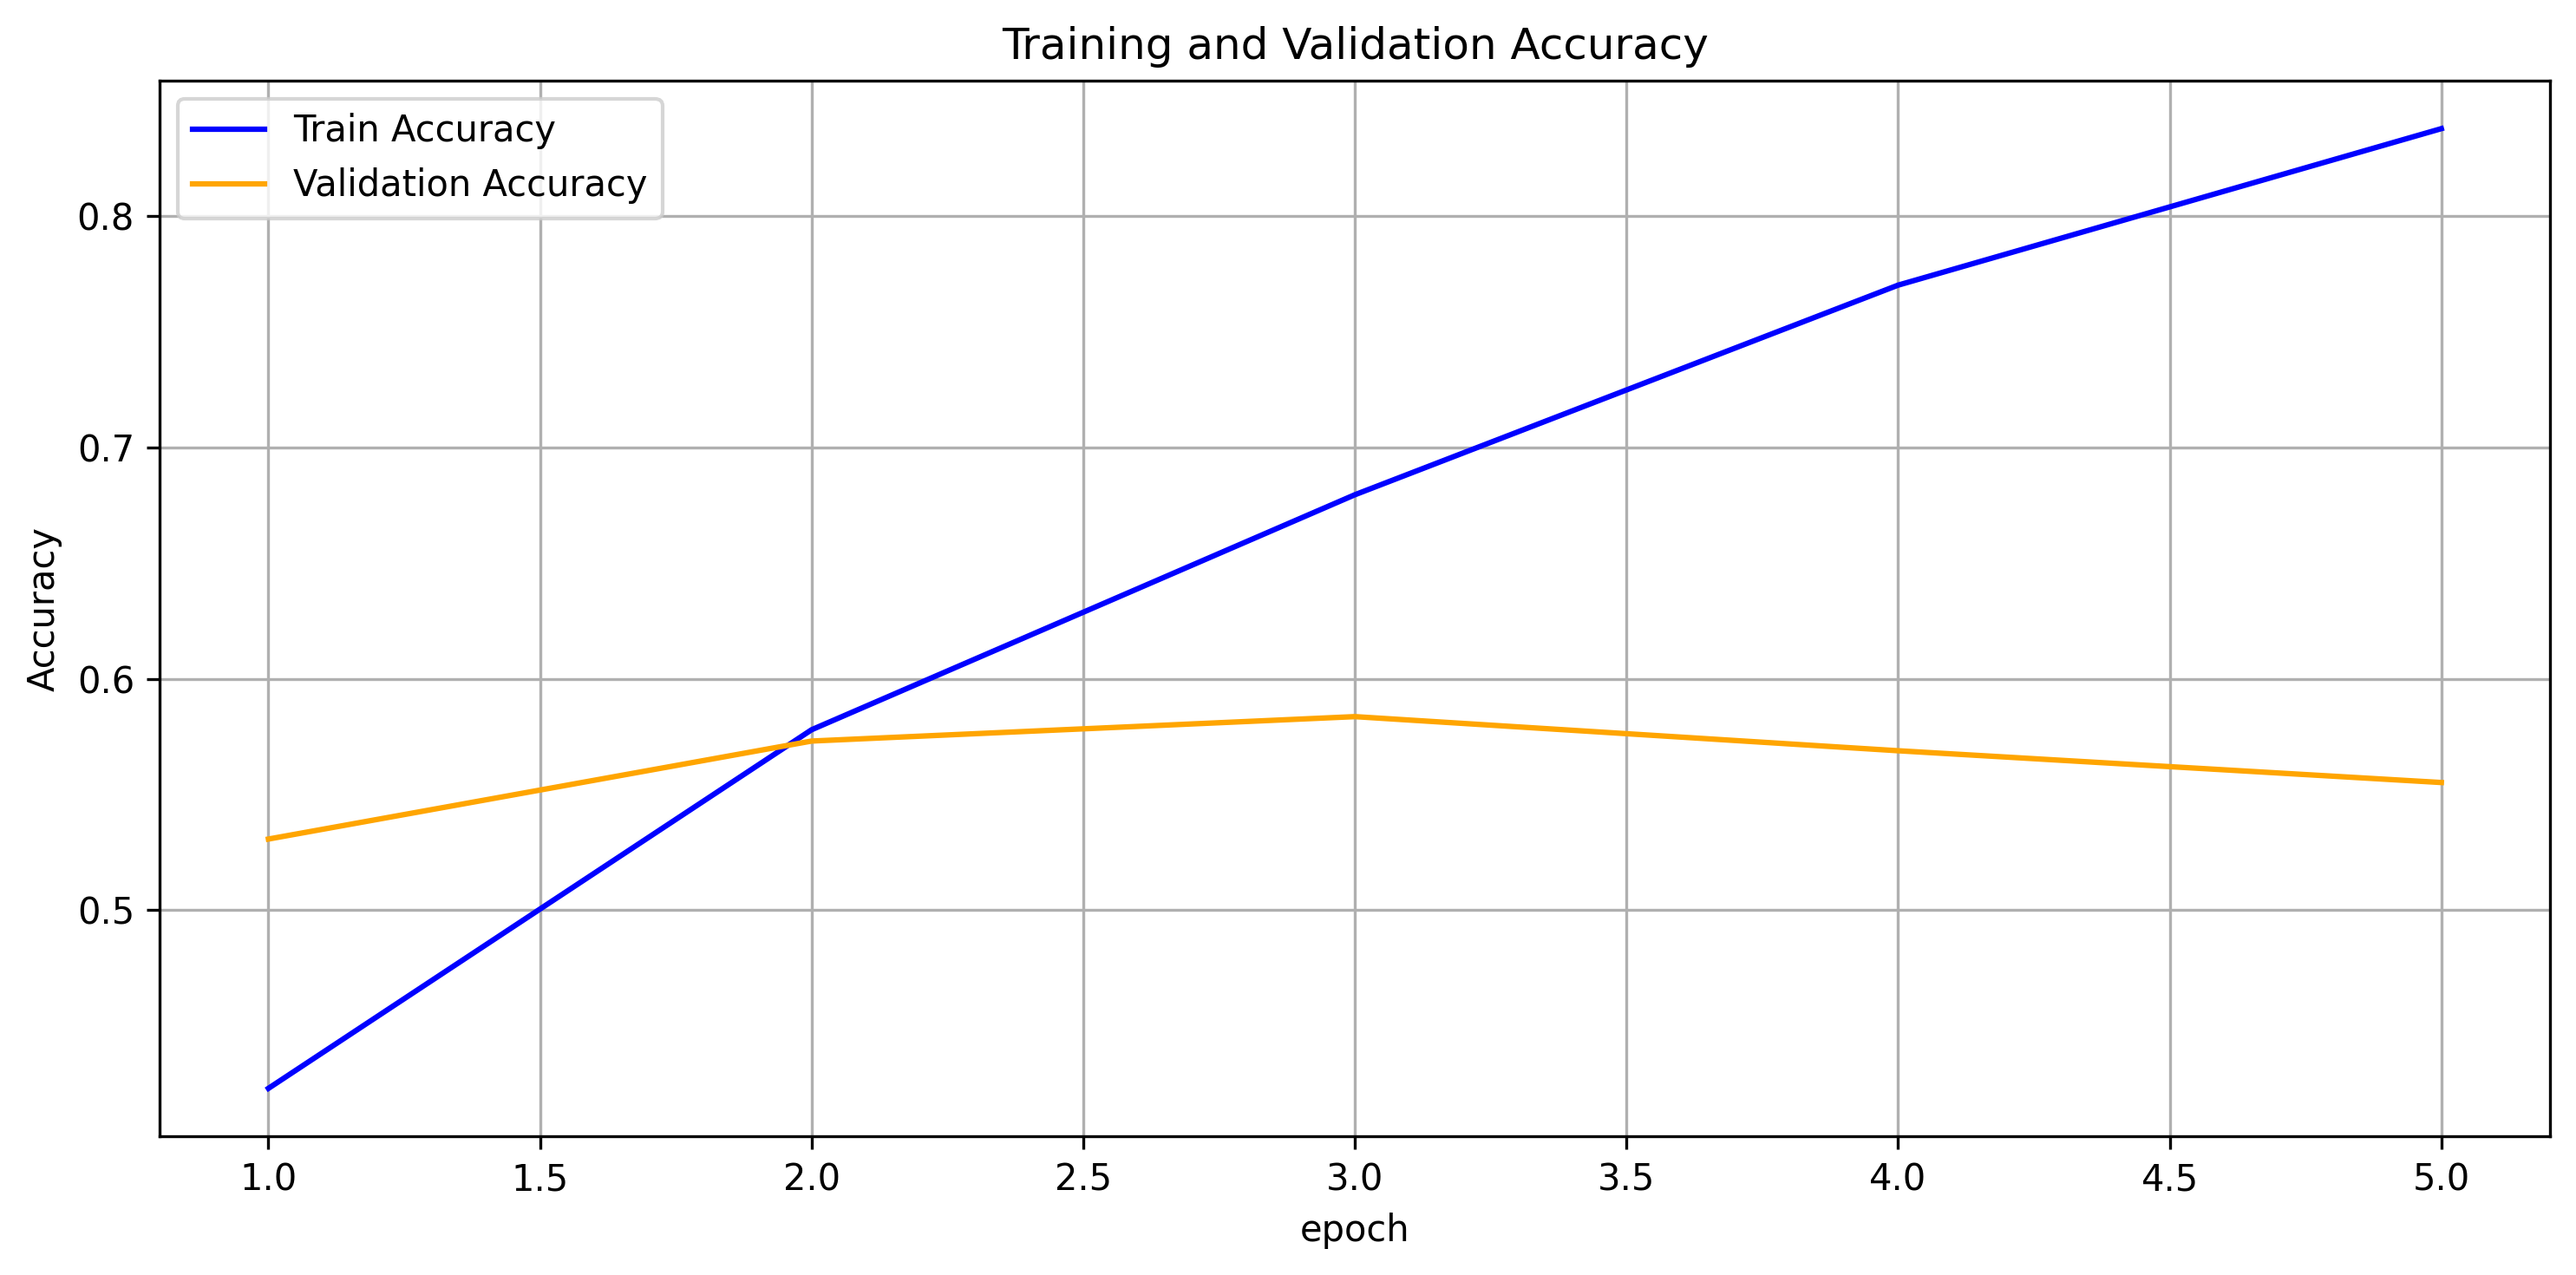

In [ ]:
plot_curves(curve['train loss'], curve['valid loss'], curve['train accuracy'], curve['valid accuracy'])